In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import keras
import re
import os
import nltk
import pickle
nltk.download('stopwords')
nltk.download('wordnet')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
#from keras.callbacks.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,model_from_json,Model
from keras.layers import Dense, Dropout, Activation,Bidirectional,Conv1D,MaxPooling1D,Flatten,GRU,SimpleRNN
from keras.layers import Embedding
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score
import sklearn
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.utils import to_categorical
from keras.applications.resnet_v2 import ResNet50V2
from keras import optimizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
data = pd.read_csv("/content/drive/My Drive/NNFL Fall'19 Project/data_7000_new.csv")

In [0]:
data.columns = ["MEME Name", "URL", "Text1", "Text2", "Sentiment_Humour", "Sentiment_General","Sentiment_Offensive","Sentiment_Motivational","Sentiment_Positive"]

In [0]:
data['Sentiment_Positive'][669] = 'positive'
data.dropna(inplace=True)

data['Sentiment_Positive'].fillna('positive',inplace=True)
pd.set_option('display.width', 2000)
print(data[data['Text2'].str.contains('funny').fillna(False) & ~data['Sentiment_Humour'].str.contains('hilarious').fillna(True) & ~data['Sentiment_Humour'].str.contains('funny').fillna(True)])


Empty DataFrame
Columns: [MEME Name, URL, Text1, Text2, Sentiment_Humour, Sentiment_General, Sentiment_Offensive, Sentiment_Motivational, Sentiment_Positive]
Index: []


In [0]:
data[data['Text2'].str.contains('nigger') | data['Text1'].str.contains('nigger') | data['MEME Name'].str.contains('nigger') ]

,MEME Name,URL,Text1,Text2,Sentiment_Humour,Sentiment_General,Sentiment_Offensive,Sentiment_Motivational,Sentiment_Positive
3252,racis_194+memes_a52fba_6202283.jpg,https://memestatic.fjcdn.com/pictures/+memes_a...,"Normie: ""Your meme's are racist and offensive","Normie: ""Your meme's are racist and offensive ...",not_funny,general,not_offensive,not_motivational,neutral
3262,racis_232black-nigger-memes.jpg,https://racistmemes.com/wp-content/uploads/201...,IF I HAD A DOLLAR FOR EVERY RACIST THING I'VE ...,IF I HAD A DOLLAR FOR EVERY RACIST THING I'VE ...,very_funny,twisted_meaning,very_offensive,motivational,neutral
5511,minion_b2b3a14c649a3561275649de293dc20ba41adf8...,https://pm1.narvii.com/6748/b2b3a14c649a356127...,I'm not clumsy It's just The niggers in my bas...,I'm not clumsy It's just The niggers in my bas...,funny,not_sarcastic,slight,not_motivational,positive


In [0]:
data['Sentiment_Offensive'].value_counts()

not_offensive        2488
slight               2353
very_offensive       1327
hateful_offensive     199
Name: Sentiment_Offensive, dtype: int64

In [0]:
print(len(data[data['Sentiment_Offensive'] == 'neutral']),
len(data[data['Sentiment_Offensive'] == 'positive']),
len(data[data['Sentiment_Offensive'] == 'negative']),
len(data[data['Sentiment_Offensive'] == 'very_positive']),
len(data[data['Sentiment_Positive'] == 'very_negative']))

0 0 0 0 133


In [0]:
print(len(data[data['Sentiment_Positive'] == 'neutral']),
len(data[data['Sentiment_Positive'] == 'positive']),
len(data[data['Sentiment_Positive'] == 'negative']),
len(data[data['Sentiment_Positive'] == 'very_positive']),
len(data[data['Sentiment_Positive'] == 'very_negative']))

2033 2845 430 926 133


In [0]:
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [0]:
for i in range(0,len(data)):
  if i not in data.index:
    continue
  text = data["Text2"][i]
  #print(text)
  text = str(text)
  bad_chars = [';', ':', '!', '*', '#','@','"','(',')']
  for j in bad_chars: 
    text = text.replace(j, ' ') 
  text = text.lower()
  text = ' '.join(word for word in text.split() if word not in STOPWORDS)
  word_list = []
  for word in text.split():
    word = lemmatizer.lemmatize(word)
    word_list.append(word)
  text = ' '.join(word for word in word_list)
  data["Text2"][i] = text 

In [0]:
#X = (data[data['Sentiment_Positive']!='neutral'])['Text2']
X=data['Text2']

In [0]:
MAX_NB_WORDS = 13000
MAX_SEQUENCE_LENGTH = 60
EMBEDDING_DIM = 200
tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X_proc = tokenizer.texts_to_sequences(X)
X_proc = pad_sequences(X_proc, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print('Shape of data tensor:', X_proc.shape)

Found 12104 unique tokens.
Shape of data tensor: (6367, 60)


In [0]:
Y = data.iloc[:,4:]

Y_motivational = Y['Sentiment_Motivational']
print(Y_motivational[0])
#Y_positive = (Y[Y['Sentiment_Positive']!='neutral'])['Sentiment_Positive']
Y_positive = (Y['Sentiment_Positive'])
Y_offensive = Y['Sentiment_Offensive']
Y_general = Y['Sentiment_General']
Y_humour = Y['Sentiment_Humour']
Y_motivational = pd.get_dummies(Y_motivational)
Y_positive = pd.get_dummies(Y_positive)
Y_offensive = pd.get_dummies(Y_offensive)
Y_general = pd.get_dummies(Y_general)
Y_humour = pd.get_dummies(Y_humour)
print(Y_positive.columns)
#print(Y.head())
#print(data.iloc[:,4:].head())

motivational
Index(['negative', 'neutral', 'positive', 'very_negative', 'very_positive'], dtype='object')


In [0]:
Y['Sentiment_Motivational'].value_counts()

not_motivational    4132
motivational        2235
Name: Sentiment_Motivational, dtype: int64

In [0]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip

In [0]:
#!unzip glove.twitter.27B.zip

In [0]:
#!unzip glove.6B.zip

In [0]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [0]:
'''with open('/content/drive/My Drive/embed/glove-twitter-27B-200d.txt', 'w') as f:
  with open('/content/glove.twitter.27B.200d.txt', 'r') as f1:
    for line in f1:
      f.write(line)
      #print(line)
'''
print()

In [0]:
'''with open('/content/drive/My Drive/embed/glove-6B-200d.txt', 'w') as f:
  with open('/content/glove.6B.200d.txt', 'r') as f1:
    for line in f1:
      f.write(line)
      #print(line)
'''
print()

In [0]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove_file = ('/content/drive/My Drive/glove-twitter-27B-200d.txt')
tmp_file = get_tmpfile("test_word2vec.txt")

_ = glove2word2vec(glove_file, tmp_file)

glove_twitter = KeyedVectors.load_word2vec_format(tmp_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
glove_twitter.most_similar(positive=['king','woman'],negative=['man'])

In [0]:
#TWITTER'''

embeddings_index = {}
f = open('/content/drive/My Drive/embed/glove-twitter-27B-200d.txt')#### have to check this part (Suhas- needs to be on colab bub,maybe import glove to google drive?,quick hack is to use wget each time)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [0]:
#NORMAL GLOVE
embeddings_index_2 = {}
f = open('/content/drive/My Drive/glove-6B-200d.txt')#### have to check this part (Suhas- needs to be on colab bub,maybe import glove to google drive?,quick hack is to use wget each time)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_2[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_2))


Found 400000 word vectors.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#TWITTER
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    try:
      embedding_vector = glove_twitter.wv[word]
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros
          embedding_matrix[i] = embedding_vector
    except:
       f=0


In [0]:
print(embedding_matrix.shape)

(12105, 200)


In [0]:
print(X_proc)

[[  35  111 4951 ...    0    0    0]
 [3263 4955 4956 ...    0    0    0]
 [ 111   27  305 ...    0    0    0]
 ...
 [4941  887  351 ...    0    0    0]
 [ 335   96  518 ...    0    0    0]
 [  42 2625  387 ...    0    0    0]]


In [0]:
np.savetxt("twitter_matrix.csv", embedding_matrix, delimiter=",")

In [0]:
#NORMAL GLOVE
# embedding_matrix_2 = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
   embedding_vector = embeddings_index_2.get(word)
   if embedding_vector is not None:
       # words not found in embedding index will be all-zeros.
       embedding_matrix_2[i] = embedding_vector


In [0]:
#TWITTER
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
#NORMAL GLOVE

embedding_layer_2 = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_2],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_proc,Y_offensive, test_size = 0.10, random_state = 42,shuffle = True)
print(X_train.shape,Y_positive.shape)
print(X_test.shape,Y_test.shape)

(5730, 60) (6367, 5)
(637, 60) (637, 4)


In [0]:
# X_proc_s = np.ones((6367,60)).reshape((-1,60,1))
# Y_proc_s = np.random.randn(6367,4)

In [0]:
from keras import optimizers

########Normal glove
modelg = Sequential()
modelg.add(embedding_layer)#### model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_proc.shape[1])) ##### making changes here maybe
#model.add(SpatialDropout1D(0.2))
#model.add((SimpleRNN(32,activation='relu',input_shape=(1,60))))
#model.add(Flatten())
#model.add(Dense(60,input_shape=(60,)))
#modelg.add((LSTM(200, activation='relu'))
modelg.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))

#model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))
#model.add(LSTM(200,kernel_initializer='zeros',activation='relu'))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(2))
#model.add(Dense(128,activation='relu'))
#model.add(Dense(64,activation='relu'))
modelg.add(Flatten())
#modelg.add(Dense(64,activation='relu',kernel_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
modelg.add(Dense(128, activation='relu'))
modelg.add(Dense(64, activation='relu'))
modelg.add(Dense(2, activation='softmax'))

print(modelg.summary())
modelg.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           2421000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 200)           320800    
_________________________________________________________________
flatten_13 (Flatten)         (None, 12000)             0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               1536128   
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 130       
Total params: 4,286,314
Trainable params: 1,865,314
Non-trainable params: 2,421,000
___________________________________

In [0]:
modelg.save('model_motivational.h5')

In [0]:
from keras.utils import plot_model
historyg = modelg.fit(X_proc, Y_motivational, epochs=20, batch_size=32,validation_split=0.1)

Train on 5730 samples, validate on 637 samples
Epoch 1/20
5730/5730 [==============================] - 53s 9ms/step - loss: 0.6511 - acc: 0.6473 - val_loss: 0.6403 - val_acc: 0.6641
Epoch 2/20
5730/5730 [==============================] - 47s 8ms/step - loss: 0.6503 - acc: 0.6473 - val_loss: 0.6410 - val_acc: 0.6641
Epoch 3/20
5730/5730 [==============================] - 47s 8ms/step - loss: 0.6498 - acc: 0.6473 - val_loss: 0.6385 - val_acc: 0.6641
Epoch 4/20
5730/5730 [==============================] - 46s 8ms/step - loss: 0.6498 - acc: 0.6473 - val_loss: 0.6418 - val_acc: 0.6641
Epoch 5/20
5730/5730 [==============================] - 47s 8ms/step - loss: 0.6499 - acc: 0.6473 - val_loss: 0.6388 - val_acc: 0.6641
Epoch 6/20
5730/5730 [==============================] - 46s 8ms/step - loss: 0.6502 - acc: 0.6473 - val_loss: 0.6388 - val_acc: 0.6641
Epoch 7/20
5730/5730 [==============================] - 46s 8ms/step - loss: 0.6497 - acc: 0.6473 - val_loss: 0.6426 - val_acc: 0.6641
Epoch 8/

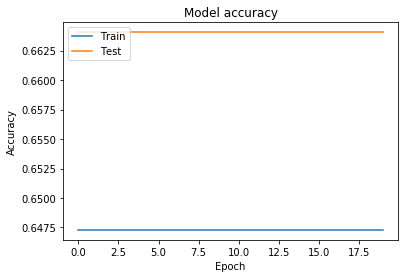

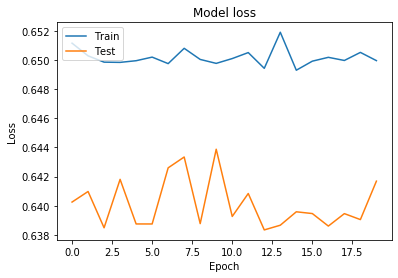

In [0]:
# Plot training & validation accuracy values
plt.plot(historyg.history['acc'])
plt.plot(historyg.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyg.history['loss'])
plt.plot(historyg.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
from keras import optimizers

#TWITTER
model = Sequential()
model.add(embedding_layer)#### model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_proc.shape[1])) ##### making changes here maybe
#model.add(SpatialDropout1D(0.2))
#model.add((SimpleRNN(32,activation='relu',input_shape=(1,60))))
#model.add(Flatten())
#model.add(Dense(60,input_shape=(60,)))
model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))
# model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))

#model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))
#model.add(LSTM(200,kernel_initializer='zeros',activation='relu'))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(2))
#model.add(Dense(128,activation='relu'))
#model.add(Dense(64,activation='relu'))
model.add(Flatten())
model.add(Dense(104,activation='relu',kernel_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
,bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
model.add(Dense(128, activation='softmax'))
model.add(Dense(64, activation='softmax'))

model.add(Dense(2, activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           2421000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 200)           320800    
_________________________________________________________________
flatten_12 (Flatten)         (None, 12000)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 104)               1248104   
_________________________________________________________________
dense_38 (Dense)             (None, 128)               13440     
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 2)              

In [0]:
from keras.utils import plot_model
history = model.fit(X_proc, Y_positive, epochs=10, batch_size=32,validation_split=0.1)

Train on 5730 samples, validate on 637 samples
Epoch 1/10
5730/5730 [==============================] - 18s 3ms/step - loss: 1.3160 - acc: 0.4442 - val_loss: 1.2475 - val_acc: 0.4505
Epoch 2/10
5730/5730 [==============================] - 17s 3ms/step - loss: 1.2715 - acc: 0.4464 - val_loss: 1.2475 - val_acc: 0.4505
Epoch 3/10
5730/5730 [==============================] - 17s 3ms/step - loss: 1.2720 - acc: 0.4464 - val_loss: 1.2459 - val_acc: 0.4505
Epoch 4/10
5730/5730 [==============================] - 17s 3ms/step - loss: 1.2716 - acc: 0.4464 - val_loss: 1.2503 - val_acc: 0.4505
Epoch 5/10
5730/5730 [==============================] - 17s 3ms/step - loss: 1.2732 - acc: 0.4464 - val_loss: 1.2460 - val_acc: 0.4505
Epoch 6/10
5730/5730 [==============================] - 17s 3ms/step - loss: 1.2722 - acc: 0.4464 - val_loss: 1.2438 - val_acc: 0.4505
Epoch 7/10
5730/5730 [==============================] - 17s 3ms/step - loss: 1.2722 - acc: 0.4464 - val_loss: 1.2469 - val_acc: 0.4505
Epoch 8/

In [0]:
twitter_model = model.save('text_positive.h5')

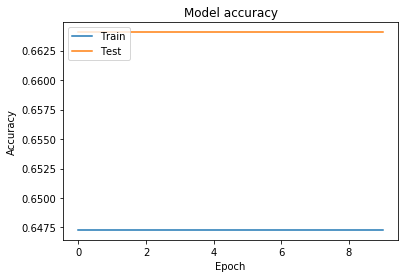

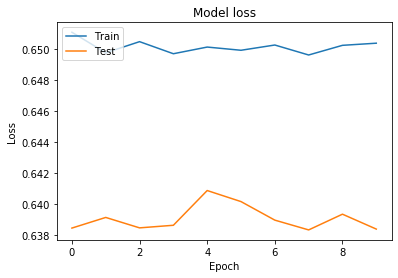

In [0]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# embed_dim = 50 #Change to observe effects
# lstm_out = 128 #Change to observe effects
# batch_size = 32
# num_classes = 4

# inputs = Input((max_length_of_text, ))
# x = Embedding(num_words, embed_dim)(inputs)  
# x = LSTM(lstm_out)(x) 
# x = Dense(num_classes, activation='sigmoid')(x)
# model = Model(inputs, x)
# print(model.summary())

##### Normal LSTM without embeddings

modelNormal = Sequential()
# # model.add(embedding_layer)####
# inputs = Input((MAX_SEQUENCE_LENGTH, ))
modelNormal.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=X_proc.shape[1])) ##### making changes here maybe
#model.add(SpatialDropout1D(0.2))
#model.add((SimpleRNN(32,activation='relu',input_shape=(1,60))))
#model.add(Flatten())
#model.add(Dense(60,input_shape=(60,)))
modeNormal.add((LSTM(200,kernel_initializer='zeros',activation='relu')))
#model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))
#model.add(LSTM(200,kernel_initializer='zeros',activation='relu'))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(2))
#model.add(Dense(128,activation='relu'))
#model.add(Dense(64,activation='relu'))

modelNormal.add(Flatten())
modelNormal.add(Dense(64,activation='relu',kernel_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
,bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
modelNormal.add(Dense(4, activation='softmax'))
print(modelNormal.summary())
modelNormal.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])

NameError: ignored

In [0]:
historyNormal = modelNormal.fit(X_proc, Y_motivational, epochs=20, batch_size=32,validation_split=0.1)

Train on 5730 samples, validate on 637 samples
Epoch 1/20
5730/5730 [==============================] - 7s 1ms/step - loss: 0.7077 - acc: 0.6279 - val_loss: 0.6429 - val_acc: 0.6641
Epoch 2/20
5730/5730 [==============================] - 2s 316us/step - loss: 0.3861 - acc: 0.8293 - val_loss: 0.8993 - val_acc: 0.5306
Epoch 3/20
5730/5730 [==============================] - 2s 323us/step - loss: 0.1246 - acc: 0.9555 - val_loss: 1.3798 - val_acc: 0.5589
Epoch 4/20
5730/5730 [==============================] - 2s 306us/step - loss: 0.0512 - acc: 0.9817 - val_loss: 1.4502 - val_acc: 0.5667
Epoch 5/20
5730/5730 [==============================] - 2s 315us/step - loss: 0.0315 - acc: 0.9899 - val_loss: 1.9310 - val_acc: 0.5463
Epoch 6/20
5730/5730 [==============================] - 2s 313us/step - loss: 0.0177 - acc: 0.9928 - val_loss: 2.1030 - val_acc: 0.5526
Epoch 7/20
5730/5730 [==============================] - 2s 313us/step - loss: 0.0192 - acc: 0.9918 - val_loss: 2.5297 - val_acc: 0.5400
Epo

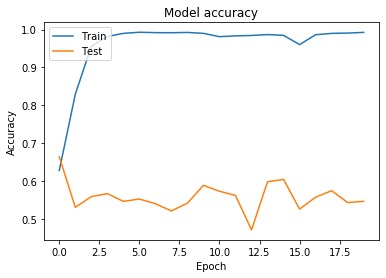

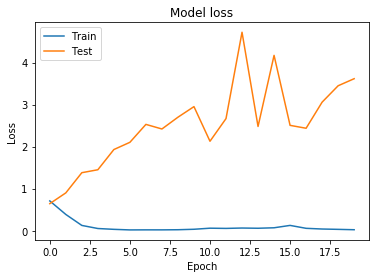

In [0]:
# Plot training & validation accuracy values
plt.plot(historyNormal.history['acc'])
plt.plot(historyNormal.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(historyNormal.history['loss'])
plt.plot(historyNormal.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
x1 = model.layers[2].get_weights()

In [0]:
x2 = model.layers[2].get_weights()

[array([[-0.02818851,  0.04366925,  0.00087268, ...,  0.01177585,
         -0.02906323, -0.04296286],
        [-0.03472773,  0.00306273, -0.02614651, ...,  0.04116422,
         -0.00804956, -0.00205766],
        [-0.02779009, -0.01088719,  0.00277435, ..., -0.03548681,
          0.01593403, -0.01989742],
        ...,
        [ 0.00334866, -0.0237309 , -0.00272692, ...,  0.00291566,
         -0.01399468, -0.0362225 ],
        [ 0.02953343,  0.04819537, -0.00152519, ..., -0.04667242,
         -0.04539862, -0.02649623],
        [ 0.0065194 , -0.00587861, -0.01335849, ..., -0.04994297,
         -0.0333499 , -0.01672566]], dtype=float32),
 array([-0.04956612, -0.0402556 , -0.05505383, -0.00545066, -0.0463523 ,
        -0.02841845,  0.01805037, -0.07546956, -0.03774472,  0.04110087,
         0.04255107, -0.02478768,  0.01599017, -0.04456089,  0.06721716,
        -0.03220953,  0.00611401, -0.01598294, -0.03382299,  0.01565853,
        -0.01582068, -0.01310624,  0.01470552, -0.02864268, -0.061

In [0]:
import keras.backend as K
fn = K.function([X_proc], K.gradients(Y_offensive, [X_proc]))

TypeError: ignored

In [0]:
print(YTU[0:100])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [0]:
model2 = Sequential()
model2.add(embedding_layer_2)#### model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_proc.shape[1])) ##### making changes here maybe
#model.add(SpatialDropout1D(0.2))
#model.add((LSTM(200)))
model2.add(Conv1D(256, 5, activation='relu'))
#model.add(MaxPooling1D(5))
model2.add(Conv1D(256, 5, activation='relu'))
model2.add(MaxPooling1D(2))
#model.add(Dense(128,activation='relu'))
#model.add(Dense(64,activation='relu'))
model2.add(Flatten())
#model.add(Dense(32,activation='relu'))
model2.add(Dense(5, activation='sigmoid'))
print(model.summary())
model2.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])


NameError: ignored

In [0]:
model2.fit(X_proc, Y_positive, epochs=40, batch_size=512,validation_split=0.1)

Train on 5730 samples, validate on 637 samples
Epoch 1/40
5730/5730 [==============================] - 0s 40us/step - loss: 1.2703 - acc: 0.4464 - val_loss: 1.2447 - val_acc: 0.4505
Epoch 2/40
5730/5730 [==============================] - 0s 36us/step - loss: 1.2703 - acc: 0.4464 - val_loss: 1.2447 - val_acc: 0.4505
Epoch 3/40
5730/5730 [==============================] - 0s 38us/step - loss: 1.2703 - acc: 0.4464 - val_loss: 1.2447 - val_acc: 0.4505
Epoch 4/40
5730/5730 [==============================] - 0s 37us/step - loss: 1.2704 - acc: 0.4464 - val_loss: 1.2449 - val_acc: 0.4505
Epoch 5/40
5730/5730 [==============================] - 0s 37us/step - loss: 1.2703 - acc: 0.4464 - val_loss: 1.2451 - val_acc: 0.4505
Epoch 6/40
5730/5730 [==============================] - 0s 38us/step - loss: 1.2703 - acc: 0.4464 - val_loss: 1.2451 - val_acc: 0.4505
Epoch 7/40
5730/5730 [==============================] - 0s 37us/step - loss: 1.2704 - acc: 0.4464 - val_loss: 1.2449 - val_acc: 0.4505
Epoch 8/

In [0]:
img_dir = "/content/drive/My Drive/NNFL Fall'19 Project/data_7000"
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=img_dir,
        x_col="MEME Name",
        y_col="Sentiment_Offensive",
        target_size=(224, 224),
        batch_size=512,
        class_mode='categorical')


Found 6366 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="MEME Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [0]:
resnet = ResNet50V2(weights='imagenet')
#resnet.trainable = False
#resnet.layers.pop()
#resnet.compile(optimizer='Adam',loss='categorical_crossentropy')
#cnn_model = resnet.layers[-1].output
#cnn_model.summary()
for layer in resnet.layers[:-1]:
  layer.trainable=False

#cnn_model.add(ResNet50V2(weights='imagenet'))
#cnn_model = cnn_model.layers[-1]
temp1 = Dense(128,activation='relu')(resnet.layers[-2].output)
temp2 = Dense(64,activation='relu')(temp1)
predictions = Dense(4, activation= 'softmax')(temp2)
img_model = Model(inputs = resnet.input, outputs = predictions)
img_model.summary()
#print(cnn_model.summary())
#img_model = Dense(2,activation='sigmoid')(cnn_model)
#cnn_model = Dense(4, activation='sigmoid')(resnet)
#img_model.summary(img_model.summary()
#resnet.summary()












102875136/102869336 [==============================] - 8s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
img_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])


In [0]:
img_model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=2
        )

Epoch 1/2


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 5 could not be retrieved. It could be because a worker has died.
  UserWarning)


 1/10 [==>...........................] - ETA: 30:26 - loss: 1.4367 - acc: 0.2676

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 9 could not be retrieved. It could be because a worker has died.
  UserWarning)


 2/10 [=====>........................] - ETA: 24:18 - loss: 1.3848 - acc: 0.3457

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 12 could not be retrieved. It could be because a worker has died.
  UserWarning)


 3/10 [========>.....................] - ETA: 17:09 - loss: 1.3550 - acc: 0.3581

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


 4/10 [===========>..................] - ETA: 15:51 - loss: 1.3814 - acc: 0.3423

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 3 could not be retrieved. It could be because a worker has died.
  UserWarning)


 5/10 [==============>...............] - ETA: 14:01 - loss: 1.3817 - acc: 0.3481

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


KeyboardInterrupt: ignored

In [0]:
from keras.models import load_model


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import skimage
from keras.models import load_model
from keras.models import model_from_json 


In [0]:
data1 = pd.read_csv("/content/drive/My Drive/data_7000_new.csv")
# data1['Sentiment_Positive'][669] = 'positive'
data1.dropna(inplace=True)
# data2 = pd.read_csv("/home/nahush/Desktop/nnfl-assignment-i/test_data_file_id.csv")
# t = cv2.imread('./data/final_train/682.jpg')
data1.columns = ["MEME Name", "URL", "Text1", "Text2", "Sentiment_Humour", "Sentiment_General","Sentiment_Offensive","Sentiment_Motivational","Sentiment_Positive"]
data1['Sentiment_Positive'][669] = 'positive'

In [0]:
# Load data

nums = re.compile(r'(\d+)')
def key(value):
    parts = nums.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts


names = data1['MEME Name']


In [0]:
len(names)

6367

In [0]:


# for i in trainingImages:
#     j = skimage.transform.rescale(i, 0.25, anti_aliasing = True)
#     trainingImages1.append(j.astype('float32') / 255.)

#test_path = './data/final_test'
trainingImages1 = []
y_train = []
c=0
for i in sorted(os.listdir("/content/drive/My Drive/NNFL Fall'19 Project/data_7000/"), key=key):
#     print(i)
    if i in names.values:
        imgFile="/content/drive/My Drive/NNFL Fall'19 Project/data_7000/"+i
        img = cv2.imread(imgFile)
        if img is not None:
            print(c)
            c+=1
    #         print(imgFile)
    #         img = cv2.imread(imgFile)
    #         print(img.shape)
            img = cv2.resize(img,(224,224))
    #         print(img.shape)
        #     print(type(img))
            img = img.astype('float32')
    #         print(type(img))
            trainingImages1.append(img/255.)
            y_train2 = data1.loc[data1['MEME Name'] == i]
            y_train2 = y_train2['Sentiment_Positive'].values[0]
            y_train.append(y_train2)
# x_train = np.asarray(trainingImages1)
        
# y_train = df.loc[df['MEME_Name'].isin(x_train)]
# y_train = y_train['Sentiment_Offensive']
# y_train = y_train.to_numpy() 

# print(y_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
print(y_train)


['neutral', 'neutral', 'very_positive', 'positive', 'positive', 'negative', 'positive', 'neutral', 'positive', 'neutral', 'negative', 'positive', 'neutral', 'neutral', 'negative', 'neutral', 'very_positive', 'positive', 'positive', 'neutral', 'negative', 'neutral', 'very_positive', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'positive', 'very_positive', 'positive', 'neutral', 'positive', 'very_positive', 'very_positive', 'very_positive', 'neutral', 'neutral', 'very_negative', 'negative', 'very_positive', 'very_positive', 'very_positive', 'positive', 'negative', 'neutral', 'very_positive', 'very_positive', 'positive', 'neutral', 'negative', 'positive', 'neutral', 'very_positive', 'positive', 'positive', 'very_positive', 'neutral', 'neutral', 'neutral', 'negative', 'positive', 'neutral', 'positive', 'very_positive', 'neutral', 'neutral', 'positive', 'very_positive', 'positive', 'neutral', 'very_positive', 'positive', 'very_positive', 'neutral', 'positive', 'neutral', 'very_

In [0]:
#Load data part2
# y_tr.dropna()
# x_train = np.asarray(trainingImages1)
x_train = np.asarray(trainingImages1)
y_train3 = pd.DataFrame(y_train)

y_train3 = pd.get_dummies(y_train3)
y_train3 = np.asarray(y_train3)
# y_train.dropna()
x_train.shape, y_train3.shape
print(y_train3)



[[0 1 0 0 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 0 1]
 [0 1 0 0 0]
 [0 1 0 0 0]]


In [0]:
y_trainCNN = y_train3

In [0]:
print(x_train.shape, y_trainCNN.shape)


(6363, 224, 224, 3) (6363, 5)


In [0]:
# EPOCHS = 8
# NUM_CLASSES = 5 # (0, 1)

In [0]:

# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=(64,64,3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(64, (3, 3),activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(Conv2D(128, (5, 5), activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(NUM_CLASSES, activation='softmax'))
# model.summary()

In [0]:
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

In [0]:
img_model.load_weights('/content/drive/My Drive/Resnet-dense128-dense5-epoch-5.h5')

In [0]:
from keras import optimizers

#LATE FUSION
twitter = Sequential()
twitter.add(embedding_layer)#### model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_proc.shape[1])) ##### making changes here maybe
#model.add(SpatialDropout1D(0.2))
#model.add((SimpleRNN(32,activation='relu',input_shape=(1,60))))
#model.add(Flatten())
#model.add(Dense(60,input_shape=(60,)))
twitter.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))
# model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))

#model.add((LSTM(200,return_sequences=True,kernel_initializer='zeros',activation='relu')))
#model.add(LSTM(200,kernel_initializer='zeros',activation='relu'))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(5))
#model.add(Conv1D(512, 3, activation='relu'))
#model.add(MaxPooling1D(2))
#model.add(Dense(128,activation='relu'))
#model.add(Dense(64,activation='relu'))
twitter.add(Flatten())
twitter.add(Dense(104,activation='relu',kernel_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
,bias_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)))
twitter.add(Dense(128, activation='softmax'))
twitter.add(Dense(64, activation='softmax'))

twitter.add(Dense(4, activation='softmax'))

print(twitter.summary())
# twitter.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 200)           2421000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 200)           320800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 12000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 104)               1248104   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               13440     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [0]:
concatenated = keras.layers.concatenate([img_model.layers[-1].output, twitter.layers[-1].output])
temp = Dense(64, activation='relu')(concatenated)
out = Dense(4,activation='softmax')(temp)
classification_model = Model(inputs=[img_model.input,twitter.input], outputs = out)
classification_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
classification_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])


In [0]:
fake_img = np.zeros([6367,224,224,3])

In [0]:
history = classification_model.fit([x_train, X_proc], y,  epochs=40, batch_size=32, validation_split=0.1)  #### x_train maybe wrong

ValueError: ignored

In [0]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()